# 加载配置文件
config/predict_config.json

In [15]:
pre_con_path = 'config/predict_config.json'

import json

# 打开一个JSON文件
with open(pre_con_path, 'r', encoding='utf-8') as file:
    # 将文件内容转换为Python字典
    paths = json.load(file)

# print(paths)

# 加载数据集
路径:C:\Users\Administrator\Desktop\college\junior2\工业大数据\实验\lab1\data\all_data_ct_10M.h5

In [2]:
import os.path

data_path = paths['data_path']

from h5Reader.readHdf5 import readH5

data,idx = readH5(data_path,datasets=['data','idx'])

# 获取数据集原始形状
8928*10000*5

In [3]:
# 原始数据集
data_shape = data.shape
num_timePoints = data_shape[0]
num_districts = data_shape[1]
num_business = data_shape[2]

print("时间点数量:%d,小区数量:%d,流量业务类型数量:%d" %(num_timePoints,num_districts,num_business))

时间点数量:8928,小区数量:10000,流量业务类型数量:5


# 根据二维地区索引重塑原始数据集
我们要先把(8928,10000,5)的数据集重塑为(8928,100,100,5)的形状
坐标映射的方式为：index -> ( index//100,index%100 )

In [9]:
import math
import numpy as np

def cor_map(data_set):
    size = int(math.sqrt(num_districts))
    
    res = np.zeros((num_timePoints,size,size,num_business),dtype=np.float64)
    for i in range(num_timePoints):
        for j in range(num_districts):
            x = j//size
            y = j%size
            for k in range(num_business):
                res[i,x,y,k] = data_set[i,j,k]
    
    return res

data = cor_map(data)

def print_dim(data_set):
    print("时间点数量:%d,行索引数量:%d,列索引数量:%d,流量业务类型数量:%d" %(data_set.shape[0],data_set.shape[1],data_set.shape[2],data_set.shape[3]))

print_dim(data)

ValueError: setting an array element with a sequence.

# 选择划定的区域
由于我的机器的硬件上限(内存最多8G)，而以长度为4的滑动窗口加载数据会直接在内存中塞9个G的数据，内存会爆掉。所以我只能改成选定某个区域，进行预测。
不过理论上我这个代码是具有可扩展性的，在硬件上限较好的机器上，完全可以选定完整的100*100的区域进行训练和预测

In [10]:
def select_region(sx,ex,sy,ey,data_set):
    m = ex-sx+1
    n = ey-sy+1
    res = np.zeros((num_timePoints,m,n,num_business),dtype=np.float64)
    # print(res.shape)
    for i in range(num_timePoints):
        for j in range(m):
            for k in range(n):
                for l in range(num_business):
                    res[i,j,k,l] = data_set[i,ex+j,ey+k,l]
    return res

# 以5045小区为中心
start_x = 46
end_x = 55
start_y = 40
end_y = 49

len_x = end_x-start_x+1
len_y = end_y-start_y+1

data = select_region(start_x,end_x,start_y,end_y,data)
print_dim(data)

时间点数量:8928,行索引数量:10,列索引数量:10,流量业务类型数量:5


IndexError: index 46 is out of bounds for axis 1 with size 10

# 划分数据集
按0.7的比重划分，总计8928个时间点，也即8928*0.8=6249.59≈6250条数据

In [11]:
seperator_index = int(np.round((num_timePoints*0.7)))
#print(seperator_index)

train_set = data[0:seperator_index,:,:]
test_set = data[seperator_index:num_timePoints,:,:]
print(train_set.shape,test_set.shape)

(6250, 10, 10, 5) (2678, 10, 10, 5)


# 构造输入输出序列
CNN希望接收的参数格式: ( batch_size, time_steps, features )
放到这个例子中就是( 样本数量, 时间步长, 特征数量 )
假设我们的时间序列的滑动窗口大小为4,构建输入输出序列

In [12]:
def restructure(set, win_size):
    x_seq,y_seq = [],[]
    shape = set.shape
    tps = shape[0]
    
    for i in range(win_size,tps):
        x_seq.append(set[i-win_size:i,:,:,:])
        y_seq.append(set[i,:,:,:])
    
    x_seq = np.array(x_seq)
    y_seq = np.array(y_seq)
    return x_seq,y_seq

window_size = 4
X_train,Y_train = restructure(train_set,window_size)
X_test,Y_test = restructure(test_set,window_size)

此时
X=(train_tps-window_size,window_size,size,size,train_business)
Y=(train_tps-window_size,size,size,train_business)

In [13]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
print(train_set.shape,test_set.shape)

(6246, 4, 10, 10, 5) (6246, 10, 10, 5)
(2674, 4, 10, 10, 5) (2674, 10, 10, 5)
(6250, 10, 10, 5) (2678, 10, 10, 5)


# 保存训练集和测试集

In [16]:
import h5py
import os
def save_data(file_path:str,file_name:str):
    with h5py.File(os.path.join(file_path,file_name),'w') as file:
        file.create_dataset('X_train',data=X_train)
        file.create_dataset('Y_train',data=Y_train)
        file.create_dataset('X_test',data=X_test)
        file.create_dataset('Y_test',data=Y_test)
    
start_x_str = str(start_x)
end_x_str = str(end_x)
start_y_str = str(start_y)
end_y_str = str(end_y)

file_name_str =  f'Dataset_{start_x_str}_{end_x_str}_{start_y_str}_{end_y_str}.h5'
restructure_data_path = paths['restructure_data_path']
save_data(restructure_data_path,file_name_str)


# 构建CNN网络模型
卷积层(32卷积核大小为3)+最大池化层+全连接层+输出层(线性激活函数)

In [17]:
print("窗口大小:%d,lenX:%d,lenY:%d,channel:%d\n" %(window_size,len_x,len_y,num_business))

import tensorflow as tf
Conv3D = tf.keras.layers.Conv3D
MaxPooling3D = tf.keras.layers.MaxPooling3D
Flatten = tf.keras.layers.Flatten
Dense = tf.keras.layers.Dense
#from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

input_shape = (window_size,len_x,len_y,num_business)

model = tf.keras.Sequential([
    # 第一个卷积层，使用32个3D卷积核，大小为3x3x3
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape, padding='same'),
    # 池化层，使用2x2x2的池化核，但可能需要调整以避免尺寸问题
    MaxPooling3D(pool_size=(2, 2, 2)),
    # 第二个卷积层，使用64个3D卷积核
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    # 另一个池化层，可能需要调整以避免尺寸问题
    MaxPooling3D(pool_size=(2, 2, 2)),
    # 将3D卷积层的输出展平为1D
    Flatten(),
    # 一个全连接层
    Dense(128, activation='relu'),
    # 输出层
    Dense(len_x*len_y*num_business),
    tf.keras.layers.Reshape((len_x,len_y,num_business))
])

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 打印模型摘要
model.summary()

窗口大小:4,lenX:10,lenY:10,channel:5

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 4, 10, 10, 32)     4352      
                                                                 
 max_pooling3d (MaxPooling3  (None, 2, 5, 5, 32)       0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 5, 5, 64)       55360     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 1, 2, 2, 64)       0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)        

# 训练模型
1. 加入早停机制
2. 训练模型
3. 绘制epoch-loss图像

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# 初始化 EarlyStopping 回调
early_stopping = EarlyStopping(
    monitor='val_loss',  # 监控的指标
    patience=3,          # 允许的没有改善的 epoch 数量
    verbose=1,           # 详细模式，输出早停信息
    restore_best_weights=True  # 恢复到最佳的模型权重
)

In [20]:
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1,callbacks=[early_stopping])

Epoch 1/100
157/157 [==============================] - 26s 163ms/step - loss: 2151.6733 - val_loss: 4091.1189
Epoch 2/100
157/157 [==============================] - 23s 147ms/step - loss: 1665.6847 - val_loss: 2718.9888
Epoch 3/100
157/157 [==============================] - 26s 168ms/step - loss: 1416.7592 - val_loss: 2471.0388
Epoch 4/100
157/157 [==============================] - 27s 171ms/step - loss: 1323.8486 - val_loss: 2637.2361
Epoch 5/100
157/157 [==============================] - 26s 168ms/step - loss: 1283.4860 - val_loss: 2110.8838
Epoch 6/100
157/157 [==============================] - 25s 156ms/step - loss: 1243.3024 - val_loss: 1921.7836
Epoch 7/100
157/157 [==============================] - 24s 151ms/step - loss: 1186.0325 - val_loss: 2013.1870
Epoch 8/100
157/157 [==============================] - 26s 166ms/step - loss: 1139.2723 - val_loss: 1769.3365
Epoch 9/100
157/157 [==============================] - 26s 165ms/step - loss: 1110.9937 - val_loss: 1648.3468
Epoch 10/1

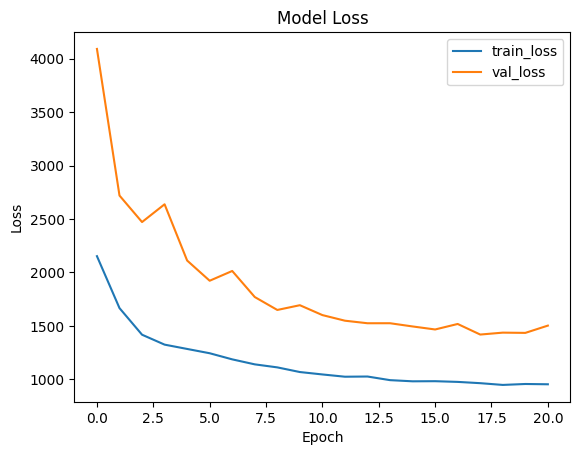

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# 保存模型
按照横纵坐标框选范围命名

In [22]:
# start_x_str = str(start_x)
# end_x_str = str(end_x)
# start_y_str = str(start_y)
# end_y_str = str(end_y)

# 构建模型文件名
model_filename = f'model_{start_x_str}_{end_x_str}_{start_y_str}_{end_y_str}.keras'

model_path = paths['model_path']
model.save(os.path.join(model_path,model_filename))

# 评估性能

In [23]:
# 评估模型
loss = model.evaluate(X_test, Y_test, verbose=1)
print(f"Test loss: {loss}")

84/84 [==============================] - 2s 21ms/step - loss: 1361.7981
Test loss: 1361.798095703125


# 模型预测

In [24]:
# 使用模型进行预测
predictions = model.predict(X_test)

84/84 [==============================] - 2s 18ms/step


# 预测值分析
1. 计算MSE和RMSE
2. 计算MAE


In [25]:
assert predictions.shape == Y_test.shape, "确保 predictions 和 Y_test 的形状相同"

# 计算MSE
mse = np.mean((predictions - Y_test) ** 2)

# 计算RMSE
rmse = np.sqrt(mse)

# 计算MAE
mae = np.mean(np.abs(predictions - Y_test))

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 16.309743063784293
MSE: 1361.798195288669
RMSE: 36.90254998355356
